In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define your dataset directory paths
train_data_dir = "/content/drive/MyDrive/Q_Learning with Transfer Leaerning/Data/train"
test_data_dir = "/content/drive/MyDrive/Q_Learning with Transfer Leaerning/Data/test"
image_size = (224, 224)
batch_size = 32

# Create an ImageDataGenerator for data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)  # Only rescale for test data

# Load and preprocess your training data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  # Assuming it's a classification task
    subset='training'
)

# Load and preprocess your validation data
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  # Assuming it's a classification task
)

# Optionally, you can print some information about your dataset
num_train_samples = train_generator.samples
num_validation_samples = test_generator.samples
num_classes = train_generator.num_classes

print("Number of training samples:", num_train_samples)
print("Number of validation samples:", num_validation_samples)
print("Number of classes:", num_classes)

Found 10500 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.
Number of training samples: 10500
Number of validation samples: 1000
Number of classes: 4


In [20]:
from tensorflow.keras.applications import VGG16,MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


In [21]:
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)  # Add more layers as needed
predictions = Dense(num_classes, activation='softmax')(x)

transfer_learning_model = Model(inputs=base_model.input, outputs=predictions)


In [22]:
transfer_learning_model.compile(optimizer=Adam(learning_rate=0.001),
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])


In [23]:
def create_q_learning_model(input_shape, num_actions):
    input_state = Input(shape=input_shape, name='state_input')
    q_values = Dense(num_actions, activation='linear', name='q_values')(input_state)
    return Model(inputs=input_state, outputs=q_values, name='q_learning_model')

q_learning_model = create_q_learning_model(input_shape=(512,), num_actions=num_classes)


In [24]:
def q_learning_loss(target_q, predicted_q):
    td_error = target_q - predicted_q
    squared_error = tf.square(td_error)
    loss = tf.reduce_mean(squared_error)
    return loss


In [25]:
q_learning_model.compile(optimizer=Adam(learning_rate=0.001),
                         loss=q_learning_loss,
                         metrics=['accuracy'])


In [26]:
combined_output = q_learning_model(transfer_learning_model.layers[-2].output)
combined_model = Model(inputs=base_model.input, outputs=combined_output, name='combined_model')


In [27]:
combined_model.compile(optimizer=Adam(learning_rate=0.001),
                       loss=q_learning_loss,
                       metrics=['accuracy'])


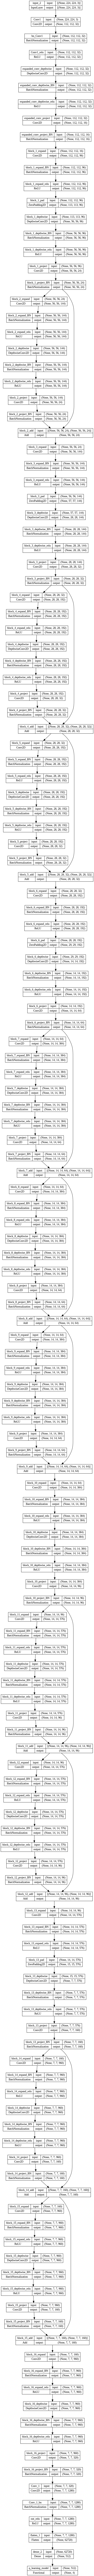

In [28]:
from tensorflow.keras.utils import plot_model

# Save the Combined Model architecture as a PNG file
plot_model(combined_model, to_file='combined_model.png', show_shapes=True, show_layer_names=True)




In [29]:
combined_history = combined_model.fit(train_generator,
                                       validation_data=test_generator,
                                       epochs=25)  # Adjust the number of epochs as needed


Epoch 1/25
329/329 [==============================] - 163s 425ms/step - loss: 33.0430 - accuracy: 0.3534 - val_loss: 273.6603 - val_accuracy: 0.3380
Epoch 2/25
329/329 [==============================] - 141s 429ms/step - loss: 0.1572 - accuracy: 0.5017 - val_loss: 17.1104 - val_accuracy: 0.2440
Epoch 3/25
329/329 [==============================] - 139s 423ms/step - loss: 0.1286 - accuracy: 0.6379 - val_loss: 4.8214 - val_accuracy: 0.2400
Epoch 4/25
329/329 [==============================] - 141s 427ms/step - loss: 0.1003 - accuracy: 0.7434 - val_loss: 0.2750 - val_accuracy: 0.5800
Epoch 5/25
329/329 [==============================] - 140s 425ms/step - loss: 0.0821 - accuracy: 0.7959 - val_loss: 0.2188 - val_accuracy: 0.7260
Epoch 6/25
329/329 [==============================] - 141s 428ms/step - loss: 0.0752 - accuracy: 0.8182 - val_loss: 0.1258 - val_accuracy: 0.8090
Epoch 7/25
329/329 [==============================] - 138s 419ms/step - loss: 0.0647 - accuracy: 0.8373 - val_loss: 0.13

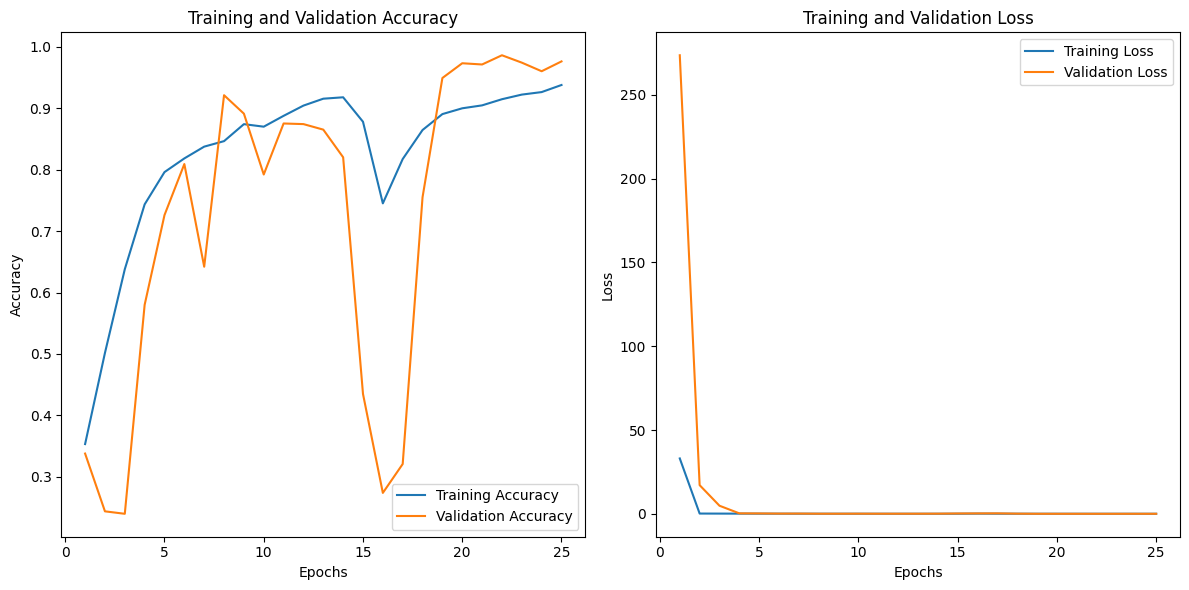

In [42]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 6))

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='lower right')

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Call the function with your combined_history variable
plot_history(combined_history)


In [30]:
transfer_learning_scores = transfer_learning_model.evaluate(test_generator)
combined_model_scores = combined_model.evaluate(test_generator)


print("Combined Model - Loss:", combined_model_scores[0], "Accuracy:", combined_model_scores[1])


32/32 [==============================] - 4s 109ms/step - loss: 0.0168 - accuracy: 0.9760
Combined Model - Loss: 0.016813846305012703 Accuracy: 0.9760000109672546


In [31]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt


In [32]:
combined_model.save('/content/drive/MyDrive/Q_Learning/combine_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [38]:
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import numpy as np

BS = 32
image_size = 0
width = 224
height = 224

# Define a dictionary with your custom loss function
custom_objects = {'q_learning_loss': q_learning_loss}

# Load the model while specifying custom_objects
classifier1 = load_model('/content/drive/MyDrive/Q_Learning with Transfer Leaerning/combine_model.h5', custom_objects=custom_objects)

validation_datagen = ImageDataGenerator(rescale = 1./255)
# Create a generator for prediction
validation_generator = validation_datagen.flow_from_directory('/content/drive/MyDrive/Q_Learning with Transfer Leaerning/Data/test',
                                                                target_size = (height, width),
                                                                batch_size = BS,
                                                                class_mode = 'categorical',
                                                                shuffle=False)

# Confution Matrix and Classification Report
Y_pred = classifier1.predict_generator(validation_generator, ((validation_generator.samples)//BS)+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['CNV', 'DME', 'DRUSEN','NORMAL']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))


Found 1000 images belonging to 4 classes.


<ipython-input-38-c2a2428e2513>:26: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = classifier1.predict_generator(validation_generator, ((validation_generator.samples)//BS)+1)


Confusion Matrix
[[231  15   4   0]
 [  0 247   0   3]
 [  1   2 245   2]
 [  0   0   0 250]]
Classification Report
              precision    recall  f1-score   support

         CNV       1.00      0.92      0.96       250
         DME       0.94      0.99      0.96       250
      DRUSEN       0.98      0.98      0.98       250
      NORMAL       0.98      1.00      0.99       250

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



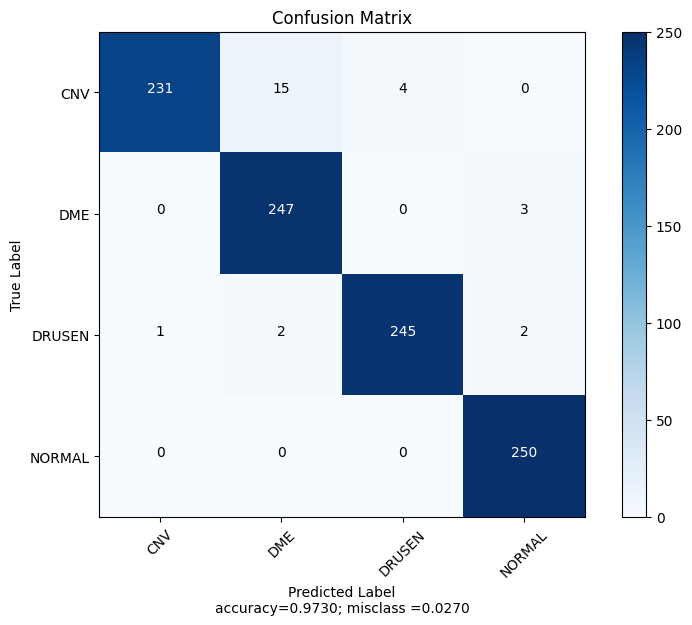

In [39]:
def plot_confusion_matrix(cm,target_names, title='Confusion Matrix', cmap = None, normalize = True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm)/float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize = (8,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation = 45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i,j]),
                     horizontalalignment = "center",
                     color = "white" if cm[i,j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i,j]),
                     horizontalalignment = "center",
                     color = "white" if cm[i,j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label\naccuracy={:0.4f}; misclass ={:0.4f}'.format(accuracy,misclass))
    plt.show()



cm = confusion_matrix(validation_generator.classes, y_pred)
plot_confusion_matrix(cm, normalize = False,
                     target_names = target_names,
                     title = "Confusion Matrix")

In [41]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(validation_generator.classes, y_pred)

# Extract TN and FP from the confusion matrix
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1] + conf_matrix[0, 2] + conf_matrix[0, 3]  # Sum of FP for all classes except 'CNV'

# Calculate specificity
specificity = TN / (TN + FP)

# Print specificity
print('Specificity: {:.2f}'.format(specificity))




Specificity: 0.92
